In [1]:
import cv2
import numpy as np
import dask as d
import matplotlib.pyplot as plt
import time
import tensorflow.keras.backend as K
import tensorflow as tf

from glob import glob
from tensorflow import test, device
# from tensorflow import keras 
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import RMSprop

In [2]:
from fl_tissue_model_tools import defs, models, data_prep
import fl_tissue_model_tools.preprocessing as prep

In [3]:
data_root_path = "D:/oxford_pets_data" # Carson
# data_root_path = "./" # Mitchell

In [4]:
img_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/images/*.jpg")])
label_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/annotations/trimaps/[!._]*.png")])

# Helper functions

In [5]:
def map2bin(lab, fg_vals, bg_vals, fg=1, bg=0):
    fg_mask = np.isin(lab, fg_vals)
    bg_mask = np.isin(lab, bg_vals)
    lab_c = lab.copy()
    lab_c[fg_mask] = fg
    lab_c[bg_mask] = bg
    return lab_c

# Validate images match labels in order & count

In [6]:
def get_img_id(img_path):
    return img_path.split("/")[-1].split(".")[0]

In [7]:
assert(all([get_img_id(img_paths[i]) == get_img_id(label_paths[i]) for i in range(len(img_paths))]))

In [8]:
assert(len(img_paths) == len(label_paths))
print(len(img_paths))

7390


# Constants

In [9]:
rand_seed = 12345
batch_size = 32
img_shape = (128, 128)
# img_size = (160, 160)
# num_classes = 2
n_outputs = 1
rs = np.random.RandomState(seed=rand_seed)
# For collapsing mask into binary range
fg_vals = [1, 3]
bg_vals = [2]
cp_filepath = "oxford_pets_toy/oxford_pets_segmentation_best_weights.h5"
cls_thresh = 0.5

# Examine data

In [10]:
preview_idx = 10

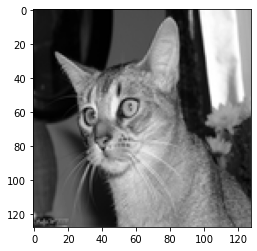

In [11]:
# img = cv2.imread(img_paths[preview_idx], cv2.IMREAD_GRAYSCALE)
img = np.expand_dims(np.array(load_img(img_paths[preview_idx], target_size=img_shape, color_mode="grayscale", interpolation="lanczos")), 2)
plt.imshow(img, cmap="gray")
plt.show()

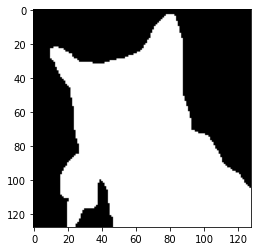

In [12]:
mask = np.expand_dims(
    np.array(load_img(label_paths[preview_idx], target_size=img_shape, color_mode="grayscale", interpolation="nearest")), 2
)
mask = map2bin(mask, fg_vals, bg_vals)
plt.imshow(mask, cmap="gray")
plt.show()

In [13]:
np.unique(mask)

array([0, 1], dtype=uint8)

# Data pipeline

In [14]:
def load_y(batch_label_paths, img_shape, fg_vals=fg_vals, bg_vals=bg_vals):
    # load the target images and condense the number of labels in the segmentation mask
    y = np.zeros((len(batch_label_paths),) + img_shape + (1,), dtype=np.uint8)
    for j, path in enumerate(batch_label_paths):
        # Use interpolation="nearest" to ensure mask is only valid bit values
        img = load_img(path, target_size=img_shape, color_mode="grayscale", interpolation="nearest")
        # add a third dimension to the array
        img = np.expand_dims(img, 2)
        # Collapse the mask from three labels to two labels
        img = map2bin(img, fg_vals, bg_vals)
        y[j] = img
    return y


def load_x(batch_img_paths, img_shape):
    # Load the input images and convert them to grayscale
    x = np.zeros((len(batch_img_paths),) + img_shape + (1,), dtype=np.float32)
    for j, path in enumerate(batch_img_paths):
        # Ensure best quality downsampling (interpolation methods overview: https://stackoverflow.com/a/44083113)
        img = load_img(path, target_size=img_shape, color_mode="grayscale", interpolation="lanczos")
        img = np.expand_dims(img, 2) # add a third dimension to the array
        x[j] = img
    return x


class BinaryMaskSequence(Sequence):
    """Helper to iterate over the data"""
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, random_state, load_x, load_y, fg_val=1, bg_val=0, sample_weights=None, augmentation_function=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.rs: np.random.RandomState = random_state
        self.load_x = load_x
        self.load_y = load_y
        self.fg_val = fg_val
        self.bg_val = bg_val
        self.sample_weights = sample_weights
        if sample_weights:
            self.fg_weight = sample_weights[self.fg_val]
            self.bg_weight = sample_weights[self.bg_val]
        self.augmentation_function = augmentation_function

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        """Returns the batch (input, target) at index `idx`"""
        # Image index, offset by batch
        i = idx * self.batch_size 
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x, y = d.compute((d.delayed(self.load_x)(batch_input_img_paths, self.img_size), d.delayed(self.load_y)(batch_target_img_paths, self.img_size)))[0]
        
        if self.augmentation_function != None:
            x, y = self.augmentation_function(x, y, self.rs)

        # If want to up/down-weight foreground/background pixel loss
        # This is good for images that tend to be imbalanced between foreground
        # and background pixel area.
        if self.sample_weights:
            batch_sample_weights = np.zeros(shape=y.shape)
            batch_sample_weights[y == self.fg_val] = self.fg_weight
            batch_sample_weights[y != self.fg_val] = self.bg_weight
            return x, y, batch_sample_weights
            
        return x, y

# Data generator demo

0.15000295639038086


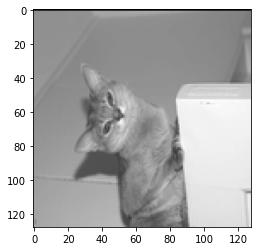

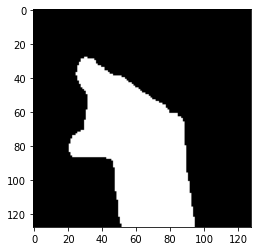

In [15]:
# pets_demo = data_prep.BinaryMaskSequence(batch_size, img_shape, img_paths, label_paths, rs, load_x, load_y, augmentation_function=augment_data)
pets_demo = BinaryMaskSequence(batch_size, img_shape, img_paths, label_paths, rs, load_x, load_y, augmentation_function=prep.augment_img_mask_pairs)
start = time.time()
X, y = pets_demo[1]
stop = time.time()
print(stop - start)
plt.imshow(X[1][:,:,0], cmap='gray')
plt.show()
plt.imshow(y[1][:,:,0], cmap='gray')
plt.show()

# Set up data generators

In [16]:
n_val = int(len(img_paths) * 0.2)
n_test = int(len(img_paths) * 0.2)
# Shuffle data
data_idx = np.array(range(len(img_paths)))
rs.shuffle(data_idx)

In [17]:
train_img_paths = img_paths[: -(n_val + n_test)]
train_label_paths = label_paths[: -(n_val + n_test)]

val_img_paths = img_paths[-(n_val + n_test): -n_test]
val_label_paths = label_paths[-(n_val + n_test): -n_test]

test_img_paths = img_paths[-n_test:]
test_label_paths = label_paths[-n_test:]

In [18]:
y_train_labels = load_y(train_label_paths, img_shape)
# Weight should be the inverse of prevalence
n_fg = np.sum(y_train_labels == 1)
n_bg = np.sum(y_train_labels == 0)
fg_weight = float(n_fg + n_bg) / (2.0 * n_fg)
bg_weight = float(n_fg + n_bg) / (2.0 * n_bg)
sample_weights = {0: bg_weight, 1: fg_weight}

In [19]:
sample_weights

{0: 0.8669675252073012, 1: 1.181259192782179}

In [20]:
train_gen = BinaryMaskSequence(batch_size, img_shape, train_img_paths, train_label_paths, rs, load_x, load_y, augmentation_function=prep.augment_img_mask_pairs, sample_weights=sample_weights)
val_gen = BinaryMaskSequence(batch_size, img_shape, val_img_paths, val_label_paths, rs, load_x, load_y, augmentation_function=prep.augment_img_mask_pairs, sample_weights=sample_weights)
# No augmentation for test_gen
test_gen = BinaryMaskSequence(batch_size, img_shape, test_img_paths, test_label_paths, rs, load_x, load_y)

# Build and train model

In [21]:
### create the model ###
K.clear_session()
# model = get_oxford_pets_model(img_size, n_classes)
# model = get_oxford_pets_model(img_size, n_outputs)
model = models.build_UNetXception(
    n_outputs,
    img_shape,
    filter_counts=(32, 64, 128, 256),
    # filter_counts=(16, 32, 64, 128),
    output_act="sigmoid"
)
# model.summary()

In [22]:
# tell tf to use the gpu
# import tensorflow as tf
device(test.gpu_device_name())

In [23]:
test.gpu_device_name()

'/device:GPU:0'

In [24]:
def mean_iou_coef(y: tf.Tensor, yhat: tf.Tensor, smooth: float=1.0, obs_axes: tuple[int, ...]=(1, 2, 3), thresh: float=0.5):
    y = K.cast(y, "float32")
    yhat = K.cast(yhat, "float32")
    # Set yhat > thresh to 1, 0 otherwise.
    yhat = K.cast(K.cast(K.greater(K.clip(yhat, 0, 1), thresh), "uint32"), "float32")
    # yhat = K.cast(K.greater(K.clip(yhat, 0, 1), thresh), "float32")
    intersection = K.sum(y * yhat, axis=obs_axes)
    union = K.sum(y, axis=obs_axes) + K.sum(yhat, axis=obs_axes) - intersection
    mean_iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    # print(mean_iou)
    return mean_iou


def mean_iou_coef_factory(smooth: int=1, obs_axes: tuple[int, ...]=(1, 2, 3), thresh: float=0.5):
    """Returns a an instance of the `iou_coef` function with extra parameters filled in.

    Allows user to use `Keras` metrics tracking without defining a lambda function.
    Returns an instance of the `iou_coef` function with the parameters below filled
    in with the values desired by the user.

    Args:
        smooth: Accounts for case of zero union. 
        obs_axes: Axes to collapse when computing IoU.
        thresh: Threshold that decides classification. Value of > 0.5
            will yield a more "picky" classification.

    """
    def fn(y, yhat):
        return mean_iou_coef(y, yhat, smooth=smooth, obs_axes=obs_axes, thresh=thresh)
    fn.__name__ = f"mean_iou_coef"
    return fn

In [25]:
### train the model ###
model.compile(optimizer=RMSprop(), loss=BinaryCrossentropy(), metrics=[models.mean_iou_coef_factory(thresh=cls_thresh)])
# model.compile(optimizer=RMSprop(), loss=BinaryCrossentropy(), metrics=[BinaryIoU(num_classes=1)])
# model.compile(optimizer=RMSprop(), loss=BinaryCrossentropy(), metrics=[MyMeanIOU(num_classes=2)])
callbacks = [ModelCheckpoint(cp_filepath, save_best_only=True, save_weights_only=True)]
num_epochs = 10
h = model.fit(train_gen, validation_data=val_gen, epochs=num_epochs, callbacks=callbacks)

Epoch 1/10
138/138 [==============================] - 34s 185ms/step - loss: 0.9635 - mean_iou_coef: 0.4830 - val_loss: 1.6445 - val_mean_iou_coef: 0.0029
Epoch 2/10
138/138 [==============================] - 25s 179ms/step - loss: 0.4908 - mean_iou_coef: 0.5812 - val_loss: 1.7400 - val_mean_iou_coef: 0.0029
Epoch 3/10
138/138 [==============================] - 25s 180ms/step - loss: 0.4248 - mean_iou_coef: 0.6346 - val_loss: 1.4789 - val_mean_iou_coef: 0.0029
Epoch 4/10
138/138 [==============================] - 25s 180ms/step - loss: 0.3904 - mean_iou_coef: 0.6611 - val_loss: 0.4246 - val_mean_iou_coef: 0.6360
Epoch 5/10
138/138 [==============================] - 25s 180ms/step - loss: 0.3707 - mean_iou_coef: 0.6798 - val_loss: 0.3497 - val_mean_iou_coef: 0.6971
Epoch 6/10
138/138 [==============================] - 25s 180ms/step - loss: 0.3516 - mean_iou_coef: 0.6938 - val_loss: 0.3397 - val_mean_iou_coef: 0.7097
Epoch 7/10
138/138 [==============================] - 25s 181ms/step -

# Load best weights

In [26]:
model.load_weights(cp_filepath)

In [47]:
test_ex_batch = 6

In [48]:
test_example_x, test_example_y = test_gen[test_ex_batch]

In [49]:
test_preds = model.predict(test_example_x)

In [50]:
np.any(np.array([float(mean_iou_coef_factory(thresh=cls_thresh)(np.expand_dims(test_example_y[i], axis=0), np.expand_dims(test_preds[i], axis=0))) for i in range(len(test_preds))]) > 1)

False

In [57]:
test_ex_idx = 20
test_ex_img = test_example_x[test_ex_idx]
test_ex_pred = test_preds[test_ex_idx]
test_ex_true = test_example_y[test_ex_idx]

In [58]:
float(models.mean_iou_coef_factory(thresh=cls_thresh)(np.expand_dims(test_ex_true, axis=0), np.expand_dims(test_ex_pred, axis=0)))

0.6058117747306824

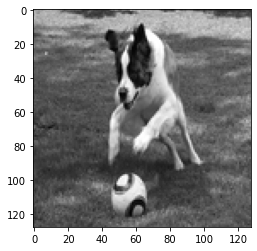

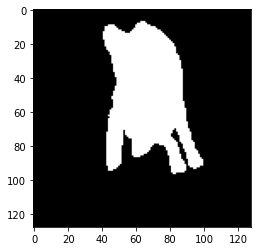

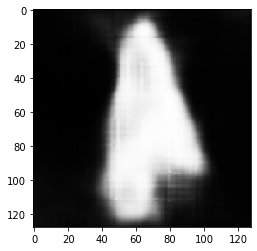

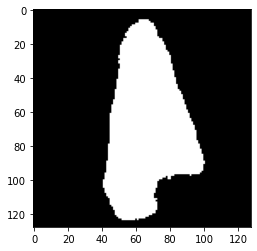

In [59]:
plt.imshow(test_ex_img, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
plt.show()
plt.imshow(test_ex_true * 255, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
plt.show()
plt.imshow(test_ex_pred * 255, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
plt.show()
plt.imshow((np.greater(test_ex_pred, cls_thresh)).astype(np.uint8) * 255, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
plt.show()